# QSR Menu Analysis Demo: SQL Queries & Competitor Image Comparison

Welcome to this enhanced tutorial! We'll explore how to use generative AI, specifically large language models (LLMs) via **LangGraph**, to interact with a Quick Service Restaurant (QSR) menu stored in a SQL database **AND** analyze competitor menus from images.

**Capabilities:**
1.  **SQL Querying:** Ask natural language questions about the internal menu database (e.g., "What vegetarian options are there?", "What's the cheapest burger?").
2.  **Competitor Menu Analysis:** Provide an image of a competitor's menu and ask the system to extract its items/prices and compare them to the internal menu database.

**Architecture:**
We use LangGraph to build a multi-agent system:
* **Supervisor Agent:** Determines if the request is for SQL querying or competitor analysis.
* **SQL Agent:** Handles natural language queries against the internal SQL database (uses SQL generation and checking).
* **Competitor Analysis Agent:** Processes the menu image, extracts data using a multimodal LLM, queries the internal database for comparison data (using the same SQL tools), and generates a comparison summary.

This notebook demonstrates how LangGraph orchestrates these interactions, including handling state, tools (SQL and image analysis), and conditional logic.

**Prerequisites:**
* Python programming knowledge.
* Basic SQL concepts.
* Fundamentals of LLMs (including multimodal concepts).
* An Ollama instance running with a suitable multimodal model (e.g., `gemma3:27b` specified here).
* Required files: `utils/qsr_db_builder.py`, `utils/result_utils.py`, `data/menu.json`, and an example `data/competitor_menu.jpg`.

## 1. Install Dependencies

First, ensure all necessary libraries are installed. We add `Pillow` for image handling and potentially updated LangChain libraries for multimodal support.

* **`sqlalchemy`**: SQL toolkit.
* **`langchain-openai`**: Integration with OpenAI-compatible APIs (like Ollama).
* **`ipython`**: For display functions.
* **`langchain-community`**: Common LangChain components (SQLDatabase, SQLDatabaseToolkit).
* **`langgraph`**: Core library for building the agent graphs.
* **`typing-extensions`**: For `TypedDict`, `Annotated`.
* **`langchain-core`**: Core LangChain abstractions.
* **`langchain`**: Helper functions and tools.
* **`pydantic`**: Data validation.
* **`Pillow`**: Python Imaging Library for handling image files.
* **`tiktoken`**: (Often needed implicitly by LangChain for token counting).

In [1]:
# Cell 1: Dependency management (Refactored)

# Ensure core libraries are installed and imported first
try:
    import sqlalchemy
except ImportError:
    print("Installing sqlalchemy...")
    %pip install -q sqlalchemy
    import sqlalchemy

try:
    # OpenAI client library is used for ChatOpenAI
    from openai import OpenAI
except ImportError:
     print("Installing openai...")
     %pip install -q openai
     # No immediate import needed here, just ensure it's installed for langchain_openai

try:
    from langchain_openai import ChatOpenAI
except ImportError:
    print("Installing langchain-openai...")
    %pip install -q langchain-openai
    from langchain_openai import ChatOpenAI

try:
    from IPython.display import Image, display
except ImportError:
    print("Installing ipython...")
    %pip install -q ipython
    from IPython.display import Image, display

try:
    from langchain_community.utilities import SQLDatabase
    from langchain_community.agent_toolkits import SQLDatabaseToolkit
except ImportError:
    print("Installing langchain-community...")
    %pip install -q langchain-community
    from langchain_community.utilities import SQLDatabase
    from langchain_community.agent_toolkits import SQLDatabaseToolkit

try:
    import langgraph
    from langgraph.prebuilt import ToolNode 
    from langgraph.graph import StateGraph, START, END
    from langgraph.graph.message import AnyMessage, add_messages
except ImportError:
    print("Installing langgraph...")
    %pip install -q langgraph
    import langgraph
    from langgraph.prebuilt import ToolNode
    from langgraph.graph import StateGraph, START, END
    from langgraph.graph.message import AnyMessage, add_messages

try:
    from typing_extensions import TypedDict, Annotated, List, Sequence, Optional, Literal
except ImportError:
    print("Installing typing-extensions...")
    %pip install -q typing-extensions
    from typing_extensions import TypedDict, Annotated, List, Sequence, Optional, Literal

try:
    # Import core components
    from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, SystemMessage
    from langchain_core.runnables import RunnableLambda, RunnableConfig
    from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
except ImportError:
    print("Installing langchain-core...")
    %pip install -q langchain-core
    from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, SystemMessage
    from langchain_core.runnables import RunnableLambda, RunnableConfig
    from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

try:
    # Import base langchain tool decorator
    from langchain.tools import tool
except ImportError:
     print("Installing langchain...")
     %pip install -q langchain
     from langchain.tools import tool

try:
    from pydantic import BaseModel, Field
except ImportError:
    print("Installing pydantic...")
    %pip install -q pydantic
    from pydantic import BaseModel, Field

try:
    from PIL import Image as PILImage
except ImportError:
    print("Installing Pillow...")
    %pip install -q Pillow
    from PIL import Image as PILImage

try:
    import tiktoken
except ImportError:
     print("Installing tiktoken...")
     %pip install -q tiktoken
     import tiktoken

# Standard library imports (no installation needed)
import os
import sys
import subprocess # Keep for installer function if needed elsewhere, though %pip is used now
import sqlite3
import re
import base64
import json
from io import BytesIO
import traceback # Useful for debugging errors

# Utility function imports (ensure files exist)
try:
    from utils.qsr_db_builder import build_qsr_menu_database
    from utils.result_utils import extract_final_response
except ImportError as e:
    print(f"ERROR: Failed to import utility functions: {e}")
    print("Ensure 'utils/qsr_db_builder.py' and 'utils/result_utils.py' exist.")
    # Define placeholders if import fails to allow the rest of the notebook to load
    build_qsr_menu_database = lambda **kwargs: create_engine(f"sqlite:///{kwargs.get('db_file', 'placeholder.db')}")
    extract_final_response = lambda result, tool_name: result.get('final_answer', 'Error: result_utils not found')

print("\nDependency check complete. All libraries should be ready!")


Dependency check complete. All libraries should be ready!


## 2. Setup Example Menu Database

We create/connect to the SQLite database representing our QSR's menu. This database will be used by both the SQL Agent and the Competitor Analysis Agent (for comparison data).

In [2]:
# Cell 2: Database Setup

DB_FILE = "sqlite:///./data/qsr_menu_enhanced.db"
DATA_DIR = "./data"
MENU_JSON_FILE = "./data/menu.json"

# Ensure utils are available and build DB
db = None
try:
    from utils.qsr_db_builder import build_qsr_menu_database
    engine = build_qsr_menu_database(db_path=DB_FILE, json_path=MENU_JSON_FILE)
    db = SQLDatabase(engine)
    print(f"Database '{DB_FILE}' created/connected and wrapped.")
    print("Usable tables:", db.get_usable_table_names())
except ImportError:
    print("Skipping database setup due to missing 'build_qsr_menu_database' utility function.")
except Exception as e:
    print(f"An error occurred during database setup: {e}")

Database created and populated from ./data/menu.json
Database 'sqlite:///./data/qsr_menu_enhanced.db' created/connected and wrapped.
Usable tables: ['menu', 'nutrition_facts']


## 3. Configure LLM

We configure a single LLM instance using `ChatOpenAI` pointed at the local Ollama endpoint. This model (`gemma3:27b`) will be used for all tasks: SQL generation, SQL checking, image analysis, comparison, and supervision. Using a multimodal model for all tasks requires careful prompting.

In [3]:
# Cell 3: LLM Configuration (Corrected)

OLLAMA_BASE_URL = "http://192.168.1.23:11434/v1"
# Define separate models for text and vision
OLLAMA_TEXT_MODEL = "llama3.3:70b-instruct-q3_K_S" 
OLLAMA_VISION_MODEL = "gemma3:27b"

text_llm = None
vision_llm = None

try:
    # Configure the Text LLM (for SQL, comparison summary, supervision, tool calls)
    text_llm = ChatOpenAI(
        base_url=OLLAMA_BASE_URL,
        model=OLLAMA_TEXT_MODEL,
        api_key="ollama",  # Required by ChatOpenAI but ignored by Ollama
        temperature=0.0     # Deterministic outputs for text tasks
    )
    print(f"Text LLM configured: Model={OLLAMA_TEXT_MODEL} at {OLLAMA_BASE_URL}")

    # Configure the Vision LLM (specifically for image analysis)
    vision_llm = ChatOpenAI(
        base_url=OLLAMA_BASE_URL,
        model=OLLAMA_VISION_MODEL,
        api_key="ollama",
        temperature=0.0 # Keep deterministic for extraction if possible
        # Potentially add vision-specific parameters if the API supports them
    )
    print(f"Vision LLM configured: Model={OLLAMA_VISION_MODEL} at {OLLAMA_BASE_URL}")

except Exception as e:
    print(f"Error configuring LLM(s): {e}")
    print("Please ensure Ollama is running and BOTH models are available at the specified URL.")

# Add a check to ensure both are loaded if subsequent steps require them
if not text_llm or not vision_llm:
     print("Warning: One or both LLMs failed to initialize. Some functionalities may be unavailable.")

Text LLM configured: Model=llama3.3:70b-instruct-q3_K_S at http://192.168.1.23:11434/v1
Vision LLM configured: Model=gemma3:27b at http://192.168.1.23:11434/v1


## 4. Define Tools

We define the tools our agents can use. This includes the existing SQL tools and new tools for image analysis and comparison.

**SQL Tools:**
* `sql_db_list_tables`: Lists tables.
* `sql_db_schema`: Gets table schema.
* `db_query_tool`: Executes SQL queries (with basic error catching).

**New Tools:**
* `analyze_competitor_menu_image`: Takes an image path, encodes the image, uses the multimodal LLM to extract menu items/prices as JSON.
* `comparison_tool`: Takes the extracted competitor JSON and data fetched from our own DB, uses the LLM to generate a comparison summary.

In [4]:
# Cell 4: Tool Definitions (Corrected)

# --- SQL Tools ---
list_tables_tool = None
get_schema_tool = None

# SQL Toolkit uses the text_llm for potential descriptions or interactions
if db and text_llm: # Check for text_llm specifically
    try:
        # Pass text_llm to the toolkit
        toolkit = SQLDatabaseToolkit(db=db, llm=text_llm)
        sql_tools = toolkit.get_tools()
        list_tables_tool = next((t for t in sql_tools if t.name == "sql_db_list_tables"), None)
        get_schema_tool = next((t for t in sql_tools if t.name == "sql_db_schema"), None)
        if not list_tables_tool or not get_schema_tool:
             print("Warning: Could not find standard list_tables or get_schema tools in toolkit.")
    except Exception as e:
        print(f"Error initializing SQLDatabaseToolkit: {e}")
else:
    print("Warning: SQL Database or Text LLM not initialized. SQL tools will be unavailable.")

from langchain.tools import tool

@tool
def db_query_tool(query: str) -> str:
    # *** REVISED DOCSTRING ***
    """Executes a provided SQLite query string ONLY against the internal database containing OUR restaurant's menu data. Use this tool specifically to retrieve information about OUR menu items, prices, categories, calories, etc., needed for comparison. Input MUST be a valid SQLite query. Returns the query results as a string, or an error message if the query fails."""
    if not db:
        return "Error: Database connection is not available."
    try:
        # Using run_no_throw might be safer if queries generated by LLM could be invalid
        result = db.run_no_throw(query)
        if result is None or result == '':
             # Provide clearer feedback if query runs but returns nothing
             return f"Query executed successfully but returned no results. Query: '{query}'"
        # Check if the result string itself indicates an error from the DB level
        if 'error' in str(result).lower():
             return f"Query execution resulted in an error: {result}"
        return str(result) # Return successful query results as string
    except Exception as e:
        error_type = type(e).__name__
        # Include the failed query in the error message for easier debugging
        return f"Error executing SQL query ({error_type}): {repr(e)}. Query: '{query}'"



# Helper function for creating tool nodes with error handling
from langgraph.prebuilt import ToolNode
# Keep handle_tool_error and create_tool_node_with_fallback as they were in the original cell
# They operate on the state and tool list structure, not directly on LLMs.
def handle_tool_error(state: dict) -> dict:
    error = state.get("error", "Unknown error")
    exception = state.get("__exception__", None)
    error_repr = repr(error) if exception is None else repr(exception)
    error_content = f"Error: Tool execution failed. Exception: {error_repr}"
    print(f"Handling Tool Error: {error_content}")
    tool_call_id = None
    messages = state.get("messages", [])
    for msg in reversed(messages):
        if isinstance(msg, AIMessage) and msg.tool_calls:
            # Ensure robust access to tool_call_id whether it's a dict or an object
            if isinstance(msg.tool_calls[0], dict):
                 tool_call_id = msg.tool_calls[0].get('id')
            else:
                 tool_call_id = getattr(msg.tool_calls[0], 'id', None)
            break

    if tool_call_id:
         tool_messages = [
            ToolMessage(
                content=error_content,
                tool_call_id=tool_call_id,
            )
        ]
    else:
        # If no tool_call_id found, return an AIMessage to signal the error generally
        tool_messages = [AIMessage(content=f"Tool execution failed: {error_content}")]

    # Return the messages wrapped in the expected state structure
    return {"messages": tool_messages}


from langchain_core.runnables import RunnableLambda
def create_tool_node_with_fallback(tool_list: List) -> RunnableLambda:
    valid_tools = [t for t in tool_list if t is not None]
    if not valid_tools:
        def no_tools_node(state):
             # Ensure state['messages'] exists or provide a default
            messages = state.get("messages", [])
            error_msg = AIMessage(content="Error: Required tools for this node are unavailable.")
            return {"messages": messages + [error_msg]} # Append error message
        return RunnableLambda(no_tools_node)

    tool_node = ToolNode(valid_tools)

    # Define the invocation function with error logging
    def safe_tool_invoke(state):
      try:
        print(f"Invoking ToolNode with tools: {[t.name for t in valid_tools]}")
        result = tool_node.invoke(state)
        # Log successful tool invocation and result type/content snippet
        messages = result.get('messages', [])
        if messages and isinstance(messages[-1], ToolMessage):
             print(f"ToolNode executed. Resulting ToolMessage content snippet: {str(messages[-1].content)[:100]}...")
        elif messages and isinstance(messages[-1], AIMessage):
             print(f"ToolNode resulted in AIMessage (likely fallback): {messages[-1].content[:100]}...")
        else:
             print(f"ToolNode executed. Result structure: {type(result)}")
        return result
      except Exception as e:
        # This exception capture might be redundant if handle_tool_error works,
        # but good for debugging the ToolNode itself.
        print(f"!!! Exception caught directly within safe_tool_invoke for ToolNode({[t.name for t in valid_tools]}): {repr(e)}")
        # Add exception info to the state for the fallback handler
        state['error'] = f"Unhandled exception in ToolNode: {repr(e)}"
        state['__exception__'] = e
        # Explicitly re-raise if fallback isn't expected to handle this type,
        # or let the fallback handle it. Assuming fallback should handle:
        return handle_tool_error(state) # Directly call fallback handler

    # Return the runnable with the defined fallback mechanism
    return RunnableLambda(safe_tool_invoke).with_fallbacks(
        fallbacks=[RunnableLambda(handle_tool_error)], # Pass the function directly
    )


# --- New Competitor Analysis Tools ---
def encode_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error encoding image {image_path}: {repr(e)}")
        return None

class CompetitorMenuItem(BaseModel):
    item_name: str = Field(...)
    price: Optional[float] = None

class CompetitorMenu(BaseModel):
    items: List[CompetitorMenuItem]

@tool
def analyze_competitor_menu_image(image_path: str) -> str:
    """Analyzes an image of a competitor's menu using a vision model and extracts menu items/prices as JSON.
    Output format: '[{"item_name": "Cheeseburger", "price": 5.99}, ...]'."""
    print(f"--- Analyzing image with Vision LLM: {image_path} ---")
    # Use vision_llm here
    if not vision_llm:
      return "Error: Vision LLM not configured."

    base64_image = encode_image(image_path)
    if not base64_image:
        return f"Error: Could not load or encode image from path: {image_path}"

    # Prepare prompt for the vision model
    schema_desc = json.dumps(CompetitorMenu.model_json_schema())
    prompt_text = (
        "Analyze the menu in the provided image. Extract all distinct menu items, their corresponding prices, and calorie information. "
        "Format the output strictly as a JSON string representing a list of objects. "
        "Each object must have keys 'item_name' (string), 'price' (float or null if price is missing or unreadable), and 'calories' (integer or null if calorie information is missing or unreadable). "
        "Ignore headers, descriptions, or non-item text. Consolidate slightly different phrasings of the same item if possible. "
        "Only output the valid JSON string, with no surrounding text, explanations, or markdown fences.\n"
        # f"The required JSON structure is described by this schema: {schema_desc}\n"
        "Example: '[{\"item_name\": \"Classic Burger\", \"price\": 6.50, \"calories\": 550}, {\"item_name\": \"Fries\", \"price\": 2.50, \"calories\": 300}, {\"item_name\": \"Soda\", \"price\": null, \"calories\": null}]'"
    )

    # Construct the message payload for a multimodal model
    message = HumanMessage(
        content=[
            {"type": "text", "text": prompt_text},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"} # Assuming JPEG, adjust if needed
            }
        ]
    )

    try:
        # Invoke the vision model
        response = vision_llm.invoke([message]) # Pass message list
        extracted_json = response.content
        print(f"--- Vision LLM response (raw): {extracted_json[:300]}... ---")

        # Attempt to clean and parse the JSON response rigorously
        cleaned_json = re.sub(r'^```json\s*', '', extracted_json.strip(), flags=re.IGNORECASE)
        cleaned_json = re.sub(r'\s*```$', '', cleaned_json.strip())

        # Find the outermost JSON array structure
        start = cleaned_json.find('[')
        end = cleaned_json.rfind(']')

        if start != -1 and end != -1 and start < end:
            json_list_str = cleaned_json[start:end+1]
            try:
                # Validate parsing and basic structure
                parsed_data = json.loads(json_list_str)
                if isinstance(parsed_data, list):
                    # Optional: Deep validation against Pydantic model if needed here
                    # competitor_menu = CompetitorMenu(items=parsed_data)
                    # return competitor_menu.model_dump_json() # Return validated JSON
                    print(f"Successfully parsed JSON list with {len(parsed_data)} items.")
                    return json.dumps(parsed_data) # Return the parsed list as a JSON string
                else:
                    error_msg = f"Error: Parsed JSON is not a list. Raw output: {extracted_json}"
                    print(error_msg)
                    return error_msg
            except json.JSONDecodeError as json_err:
                error_msg = f"Error: Failed to decode JSON from vision model response: {json_err}. Response snippet: {json_list_str[:200]}"
                print(error_msg)
                return error_msg
            except Exception as validation_err: # Catch Pydantic validation errors if used
                error_msg = f"Error: JSON structure validation failed: {validation_err}. Response snippet: {json_list_str[:200]}"
                print(error_msg)
                # Return the raw parsed data if validation fails but parsing worked, or an error
                return f"Error: JSON structure validation failed. Data: {json_list_str}"
        else:
            error_msg = f"Error: Could not find valid JSON list structure '[...]' in vision model output: {cleaned_json[:200]}"
            print(error_msg)
            return error_msg # Return specific error about structure

    except Exception as e:
        print(f"Error during multimodal LLM call: {repr(e)}")
        # Provide more context in the error returned by the tool
        return f"Error: Failed to analyze image with Vision LLM ({type(e).__name__}). {repr(e)}"


@tool
def comparison_tool(competitor_data_json: str, own_menu_data_str: str) -> str:
    """Compares competitor_data_json (list of competitor items/prices) to own_menu_data_str (string representation of own menu items/prices) using the text LLM and returns a natural language summary."""
    print("--- Comparing Menus using Text LLM ---")
    # Use text_llm here
    if not text_llm:
      return "Error: Text LLM not configured for comparison."

    # Basic validation of inputs
    try:
        competitor_list = json.loads(competitor_data_json)
        if not isinstance(competitor_list, list):
             raise ValueError("Competitor data is not a JSON list.")
    except (json.JSONDecodeError, ValueError) as e:
        return f"Error: Invalid competitor data format. Expected JSON list. Error: {e}. Data: {competitor_data_json[:100]}..."

    if not own_menu_data_str or 'error' in own_menu_data_str.lower() or own_menu_data_str.strip() == 'Query executed successfully but returned no results':
      # Handle case where own data query failed or returned nothing
      return f"Error: Cannot compare due to invalid or empty own menu data: {own_menu_data_str[:100]}..."

    # Clean data for the prompt (prevent markdown injection issues)
    safe_competitor_json = json.dumps(competitor_list, indent=2) # Re-serialize cleaned data
    safe_own_data = own_menu_data_str.replace('```', '` ` `') # Basic sanitization

    # Construct a clear prompt for the text LLM
    prompt = f"""You are a helpful menu analysis assistant.
        Analyze and compare the two menus provided below.

        **Competitor's Menu (extracted from image):**
        ```json
        {safe_competitor_json}
        Our Menu (from database):
        {safe_own_data}
        Please provide a concise comparison summary covering these points:

        Price Comparison: Identify items with similar names on both menus and compare their prices. Note any significant price differences (e.g., competitor cheaper/more expensive).
        Competitor Exclusives: List key items or categories found only on the competitor's menu.
        Our Exclusives: List key items or categories found only on our menu.
        Overall Impression: Briefly summarize the main differences (e.g., price range, variety).
        Format the output clearly using markdown. Be factual and objective based only on the data provided. If data is missing (e.g., null prices), acknowledge that.
        """
    try:
    # Invoke the text model
        response = text_llm.invoke(prompt)
        print(f"--- Text LLM comparison summary generated. Length: {len(response.content)} ---")
        return response.content
    except Exception as e:
        print(f"Error during comparison LLM call: {repr(e)}")
        return f"Error: Failed to generate comparison summary with Text LLM ({type(e).__name__}). {repr(e)}"
    
    # --- Final Answer Tool Model (Shared) ---
class SubmitFinalAnswer(BaseModel):
    """Use this tool ONLY to submit the final, complete, markdown-formatted comparison summary to the user AFTER all necessary data has been gathered and analyzed. This is the mandatory final step."""
    answer: str = Field(..., description="The final, comprehensive, markdown-formatted comparison summary for the user.")



# Rebuild the tool list, ensuring None values are handled later
all_tools_definitions = [
    list_tables_tool,
    get_schema_tool,
    db_query_tool,
    analyze_competitor_menu_image, # Uses vision_llm internally
    comparison_tool,               # Uses text_llm internally
    SubmitFinalAnswer              # This is the Pydantic model, used for binding/schemas
]

# Filter out None values and separate Pydantic models from callable tools
available_tools_runtime = [t for t in all_tools_definitions if t is not None and callable(getattr(t, 'invoke', None))]
available_pydantic_models = [t for t in all_tools_definitions if isinstance(t, type) and issubclass(t, BaseModel)]

available_tool_names = [t.name for t in available_tools_runtime]
print(f"Available callable tools for execution nodes: {available_tool_names}")
print(f"Available Pydantic models for binding: {[m.__name__ for m in available_pydantic_models]}")

# Tools specifically for the SQL Agent (needs SubmitFinalAnswer model for binding)
sql_agent_callable_tools = [list_tables_tool, get_schema_tool] # Tools it might call directly via AIMessage
sql_agent_binding_tools = sql_agent_callable_tools + [SubmitFinalAnswer] # Models/tools for the LLM bind_tools

# Tools for Competitor Agent planning (it plans calls, nodes execute them)
# Note: The planning nodes themselves construct the AIMessage tool calls deterministically in this setup.
# The execution nodes need the actual tool objects.
competitor_callable_tools = [analyze_competitor_menu_image, db_query_tool, comparison_tool]
competitor_binding_tools = [SubmitFinalAnswer] # Only needs SubmitFinalAnswer for planning the final step

    

Available callable tools for execution nodes: ['sql_db_list_tables', 'sql_db_schema', 'db_query_tool', 'analyze_competitor_menu_image', 'comparison_tool']
Available Pydantic models for binding: ['SubmitFinalAnswer']


## 5. Define LangGraph Workflow: SQL Agent

This section defines the graph for handling standard SQL queries. It includes the agent node, checker node, and SQL tool execution nodes.

In [5]:
# Cell 5: SQL Agent Graph Definition (Corrected check_sql_query_node & LLM usage)

from langgraph.graph import StateGraph
# Imports like AIMessage, ToolMessage etc. assumed from Cell 1
# Ensure re is imported if not already done in Cell 1
import re
from typing import Sequence # Added for type hinting

# --- SQL Agent State Definition ---
class SQLAgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

# --- System Prompts ---
generic_system_instructions = """You are an expert SQL agent querying a SQLite database containing restaurant menu information.
Your **primary goal** is to provide a final, natural language answer to the user's question by generating the necessary SQL query/queries, interpreting the results, and finally calling the `SubmitFinalAnswer` tool with the complete answer.

Process:
1.  Receive the user's question.
2.  If needed, use `sql_db_list_tables` to see available tables.
3.  If table structure is unknown, use `sql_db_schema` for relevant tables.
4.  Based on the schema and question, generate the *correct* SQL query needed to answer the question. Output this query directly in your response, preferably formatted like ```sql\nSELECT ...\n```. Do NOT call the query tool directly yourself yet.
5.  The system will check your SQL query for correctness.
6.  You will receive the results of the executed query (or an error message).
7.  Interpret the query results in the context of the original question.
8.  Formulate a final, natural language answer.
9.  Call the `SubmitFinalAnswer` tool, providing the complete answer in the `answer` argument.

**Important:**
* Always wait for the query results before formulating the final answer.
* If a query fails or returns unexpected results, explain the issue and try to recover (e.g., by asking for clarification or trying a different query) or state that the question cannot be answered.
* Only use the tools provided: `sql_db_list_tables`, `sql_db_schema`, and `SubmitFinalAnswer`. Do NOT attempt to call `db_query_tool`.
"""

checker_system_instructions = """You are an expert SQLite engineer. Your task is to validate and, if necessary, correct a proposed SQL query based on the provided database schema and the original user question.

Instructions:
1.  Review the `schema`, `question`, and the proposed `query`.
2.  Check if the query syntax is valid for SQLite.
3.  Check if the query correctly addresses the user's `question` using the available `schema`. Ensure correct table names, column names, joins, and filtering conditions are used.
4.  If the query is valid and correct, output the original query exactly as it is.
5.  If the query is invalid or incorrect, correct it. Output *only* the final, corrected, valid SQLite query.
6.  Do NOT add any explanations, comments, or markdown formatting (like ```sql). Output only the SQL string.
7.  If the query cannot be corrected to answer the question based on the schema (e.g., required information is missing), output the original query and trust the execution step will handle the error.
"""


# --- Graph Definition ---
sql_workflow = StateGraph(SQLAgentState)

# --- Tool Nodes (using helper from Cell 4) ---
# Ensure tools are available before creating nodes
sql_list_tables_node = create_tool_node_with_fallback([list_tables_tool] if list_tables_tool else [])
sql_schema_node = create_tool_node_with_fallback([get_schema_tool] if get_schema_tool else [])
sql_query_node = create_tool_node_with_fallback([db_query_tool] if db_query_tool else []) # Node to EXECUTE the query

sql_workflow.add_node("list_tables_tool", sql_list_tables_node)
sql_workflow.add_node("get_schema_tool", sql_schema_node)
sql_workflow.add_node("execute_db_query", sql_query_node) # Executes the query checked by query_checker

# --- LLM Chains (using text_llm) ---
sql_agent_chain = None
checker_chain = None

if text_llm: # Check for text_llm
    # SQL Agent Chain (uses text_llm)
    sql_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=generic_system_instructions),
        MessagesPlaceholder(variable_name="messages")
    ])
    # Filter tools for binding (ensure they are not None)
    # sql_agent_binding_tools defined in Cell 4 correction
    llm_with_sql_agent_tools = text_llm.bind_tools(
         [tool for tool in sql_agent_binding_tools if tool is not None]
    )
    sql_agent_chain = sql_prompt | llm_with_sql_agent_tools

    # SQL Checker Chain (uses text_llm)
    checker_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=checker_system_instructions),
        # Use a clear structure for the checker input
        HumanMessage(content="Schema:\n{schema}\n\nUser Question:\n{question}\n\nProposed Query:\n```sql\n{query}\n```\n\nOutput only the corrected/validated SQLite query string.")
    ])
    checker_chain = checker_prompt | text_llm
else:
    print("Warning: Text LLM not available. SQL Agent and Checker chains not created.")


# --- Agent Nodes ---
def sql_agent_node(state: SQLAgentState):
    """Invokes the SQL Agent LLM chain to decide the next action or generate SQL."""
    print("--- Running Node: sql_agent_node ---")
    if not sql_agent_chain:
        # Append error message to existing messages
        messages = state.get("messages", [])
        error_msg = AIMessage(content="Error: SQL Agent LLM chain is not available.")
        return {"messages": messages + [error_msg]}

    messages = state.get("messages", [])
    # Prevent infinite loops: add a max iterations check? Or rely on LangGraph's recursion limit.
    print(f"sql_agent_node: Input messages count: {len(messages)}")
    if messages:
      print(f"sql_agent_node: Last message type: {type(messages[-1])}")
      if isinstance(messages[-1], AIMessage):
          print(f"sql_agent_node: Last AI message content snippet: {messages[-1].content[:100]}")
          print(f"sql_agent_node: Last AI message tool calls: {messages[-1].tool_calls}")
      elif isinstance(messages[-1], ToolMessage):
           print(f"sql_agent_node: Last Tool message name: {messages[-1].name}")
           print(f"sql_agent_node: Last Tool message content snippet: {messages[-1].content[:100]}")


    try:
        # Invoke the main SQL agent LLM
        response = sql_agent_chain.invoke({"messages": messages})
        # The response should be an AIMessage, potentially with tool calls or SQL in content
        print(f"sql_agent_node: Response AIMessage content snippet: {response.content[:100]}")
        print(f"sql_agent_node: Response AIMessage tool calls: {response.tool_calls}")
        # Return the response wrapped in the state dictionary format
        # add_messages reducer will handle appending
        return {"messages": [response]}
    except Exception as e:
        print(f"!!! Error in SQL Agent node invocation: {repr(e)}")
        error_msg = AIMessage(content=f"Error invoking SQL Agent LLM: {repr(e)}")
        return {"messages": messages + [error_msg]} # Append error

sql_workflow.add_node("sql_generation", sql_agent_node)


# Helper functions to extract info from messages (Keep as is from original)
def find_last_sql_query(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Finds the last SQL query generated by an AIMessage, handling markdown fences."""
    for msg in reversed(messages):
        if isinstance(msg, AIMessage) and msg.content:
            # Regex to find SQL block, tolerant of optional ```sql marker and leading/trailing whitespace
            match = re.search(r"```(?:sql)?\s*(SELECT.*?)(?:```|$)", msg.content, re.IGNORECASE | re.DOTALL | re.MULTILINE)
            if match:
                return match.group(1).strip()
            # Fallback for plain SQL queries if no markdown fence found
            # Be careful not to match SQL *within* explanations
            # Check if the message *primarily* looks like SQL
            content_stripped = msg.content.strip()
            if content_stripped.upper().startswith(("SELECT ", "WITH ")) and '\n' not in content_stripped[:10]: # Simple heuristic
                 # Avoid matching if it looks like conversational text containing SQL words
                 if len(content_stripped.split()) > 3 and '\n' not in content_stripped: # Likely part of a sentence
                      continue
                 return content_stripped
    print("find_last_sql_query: No SQL query found in recent AIMessages.")
    return None

def find_last_schema(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Finds the last relevant schema description from Tool or AI messages."""
    schema_content = None
    # Prefer schema from a successful ToolMessage (means tool was actually called)
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage):
             # Check tool name if available, otherwise rely on content marker
             tool_name = getattr(msg, 'name', '')
             is_schema_tool = tool_name == (get_schema_tool.name if get_schema_tool else '')
             # Check content as fallback or primary identifier
             is_schema_content = "create table" in msg.content.lower() and "error" not in msg.content.lower()

             if is_schema_tool and is_schema_content:
                 schema_content = msg.content
                 break
             elif is_schema_content: # If tool name missing but content matches
                 schema_content = msg.content
                 # continue searching in case a named tool message exists earlier

    # If no ToolMessage schema found, check AIMessage content (less reliable)
    if not schema_content:
        for msg in reversed(messages):
             if isinstance(msg, AIMessage) and msg.content and "create table" in msg.content.lower():
                 # Extract potentially relevant part if mixed with explanation? For now, take full content.
                 schema_content = msg.content
                 break # Take the latest one

    if schema_content:
        print(f"find_last_schema: Found schema information. Snippet: {schema_content[:100]}...")
    else:
         print("find_last_schema: No schema information found in messages.")
    return schema_content


def find_question(messages: Sequence[AnyMessage]) -> Optional[str]:
    """Finds the initial HumanMessage question."""
    for msg in messages:
        if isinstance(msg, HumanMessage):
            content = getattr(msg, 'content', None)
            if isinstance(content, str):
                print(f"find_question: Found question: {content[:100]}...")
                return content
            elif isinstance(content, list): # Handle multimodal messages if needed
                 for item in content:
                     if isinstance(item, dict) and item.get("type") == "text":
                         text_content = item.get("text","")
                         print(f"find_question: Found question (from list): {text_content[:100]}...")
                         return text_content
    print("find_question: No HumanMessage question found.")
    return None

# *** CORRECTED check_sql_query_node Function ***
def check_sql_query_node(state: SQLAgentState):
    """Uses the checker_chain to validate/correct the SQL proposed by the agent."""
    print("--- Running Node: query_checker ---")
    messages = state.get('messages', [])

    if not checker_chain:
        print("Query checker Error: SQL Checker Chain not available.")
        # Append error message and return
        error_msg = AIMessage(content="Error: SQL Checker Chain not available.")
        return {"messages": messages + [error_msg]} # Append error

    # --- Extract necessary info ---
    proposed_query = find_last_sql_query(messages)
    schema = find_last_schema(messages)
    question = find_question(messages) # Get the original question for context

    # --- Input Validation ---
    if not proposed_query:
        # This indicates the agent didn't output SQL when it was expected to.
        # This node should only be reached if the agent *intended* to provide SQL.
        print("Query checker Error: No SQL query found in the last AI message to check.")
        # Return an informative message to guide the agent back.
        error_msg = AIMessage(content="Query check failed: No SQL query was found in the previous step. Please generate the SQL query.")
        return {"messages": messages + [error_msg]}

    if not schema:
         # Agent tried to query without schema. Guide it to use schema tools.
         print("Query checker Info: Schema information is missing.")
         # Should the checker try to fetch schema? No, let the agent handle it.
         # Return a message guiding the agent.
         info_msg = AIMessage(content="Schema information is missing. Please use the `sql_db_schema` tool to get the table structure before generating the query.")
         return {"messages": messages + [info_msg]}

    if not question:
        # Should not happen if flow starts correctly, but handle defensively.
        print("Query checker Error: Could not find the original user question for context.")
        error_msg = AIMessage(content="Error: Could not find the original user question needed for context during query check.")
        return {"messages": messages + [error_msg]}

    print(f"Query checker: Checking Query: {proposed_query[:150]}...")
    print(f"Query checker: Using Schema: {schema[:150]}...")
    print(f"Query checker: Original Question: {question[:150]}...")

    # --- Invoke Checker LLM ---
    try:
        checked_sql_response = checker_chain.invoke({
            "schema": schema,
            "question": question,
            "query": proposed_query # Pass the extracted SQL
        })
        checked_sql_string = checked_sql_response.content.strip()
        print(f"Query checker: Raw response from checker LLM: '{checked_sql_string}'")

        # --- Validate Checker Output ---
        # Remove potential markdown fences JUST IN CASE the checker added them despite instructions
        checked_sql_string = re.sub(r"^```(?:sql)?\s*", "", checked_sql_string, flags=re.IGNORECASE | re.DOTALL)
        checked_sql_string = re.sub(r"```$", "", checked_sql_string).strip()

        # Basic check: Does it look like SQL? (Starts with SELECT/WITH)
        if not re.match(r"^(SELECT|WITH)\b", checked_sql_string, re.IGNORECASE):
            # Checker LLM likely failed or returned an explanation instead of SQL.
            error_msg_content = f"SQL check failed: The checker did not return a valid SQL query starting with SELECT or WITH. Checker response: '{checked_sql_string}'. The original query was: '{proposed_query}'"
            print(f"Query checker Warning: {error_msg_content}")
            # Return this error to the main agent to handle.
            error_msg = AIMessage(content=error_msg_content)
            return {"messages": messages + [error_msg]}

        # --- Prepare Tool Call for Execution ---
        # If the checked SQL looks valid, prepare the call to the db_query_tool node
        print(f"Query checker: SQL validated/corrected to: {checked_sql_string[:150]}...")

        # Generate a unique ID for the tool call
        tool_call_id = f"checked_db_query_{len(messages)}"

        # Construct the tool call dictionary expected by LangGraph/LangChain
        # Ensure db_query_tool is available
        if not db_query_tool:
             error_msg = AIMessage(content="Error: `db_query_tool` is not available to execute the checked query.")
             return {"messages": messages + [error_msg]}

        tool_call_dict = {
            "name": db_query_tool.name,
            "args": {"query": checked_sql_string}, # Arguments for the tool
            "id": tool_call_id                  # Unique ID for this call
        }

        # Create an AIMessage that contains the request to call the tool
        # The content can be empty or a brief note. The key part is the tool_calls list.
        checked_sql_tool_call_msg = AIMessage(
            content=f"Checked query is ready. Executing: ```sql\n{checked_sql_string}\n```", # Optional explanatory content
            tool_calls=[tool_call_dict] # MUST be a list of tool call dicts
        )
        print(f"Query checker: Proposing execution of checked query via tool call ID {tool_call_id}.")
        # Return the AIMessage containing the tool call request
        # The add_messages reducer will append this to the state's messages list
        return {"messages": [checked_sql_tool_call_msg]}

    except Exception as e:
        # Catch errors during the checker LLM invocation or processing
        error_content = f"Error during SQL query checking phase: {repr(e)}"
        print(f"!!! Query checker Exception: {error_content}\n{traceback.format_exc()}")
        # Return an error message to the graph state
        error_msg = AIMessage(content=error_content)
        return {"messages": messages + [error_msg]}


sql_workflow.add_node("query_checker", check_sql_query_node)


# --- Routing Logic ---
def sql_decide_next_step(state: SQLAgentState) -> str:
    """Determines the next node to execute based on the last message."""
    print("--- Running Node: sql_decide_next_step ---")
    messages = state.get("messages", [])
    if not messages:
        print("Decision: No messages found, ending.")
        return END # Should not happen with START -> sql_generation

    last_message = messages[-1]
    print(f"Decision: Analyzing last message of type: {type(last_message)}")

    if isinstance(last_message, ToolMessage):
        # After a tool (list_tables, get_schema, execute_db_query) runs, go back to the agent to process results.
        tool_name = getattr(last_message, 'name', '[unknown tool]')
        print(f"Decision: Last message was ToolMessage from tool '{tool_name}'. Routing to sql_generation.")
        return "sql_generation"

    elif isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            # AI requested a tool call
            # Tool calls are now structured dictionaries or objects with 'name'
            tool_call = last_message.tool_calls[0]
            # Robustly get the tool name
            tool_name = tool_call.get("name") if isinstance(tool_call, dict) else getattr(tool_call, 'name', None)
            print(f"Decision: Last message is AIMessage requesting tool call for '{tool_name}'.")

            # Check which tool is being called
            if tool_name == SubmitFinalAnswer.__name__:
                 print("Routing to END (Final Answer requested).")
                 # The supervisor will handle extracting the answer.
                 # Or, if SubmitFinalAnswer had its own node: return "submit_final_answer_node"
                 return END # End the SQL agent subgraph execution
            elif list_tables_tool and tool_name == list_tables_tool.name:
                 print(f"Routing to execute tool: list_tables_tool.")
                 return "list_tables_tool"
            elif get_schema_tool and tool_name == get_schema_tool.name:
                 print(f"Routing to execute tool: get_schema_tool.")
                 return "get_schema_tool"
            elif db_query_tool and tool_name == db_query_tool.name:
                 # This path is specifically triggered *after* the query_checker node
                 # prepares the AIMessage with the call to db_query_tool.
                 print(f"Routing to execute checked query: execute_db_query.")
                 return "execute_db_query"
            else:
                 # Unknown tool requested or tool not available
                 print(f"Decision: Unknown or unavailable tool '{tool_name}' requested. Routing back to sql_generation.")
                 # Maybe add an error message here?
                 # state['messages'] = messages + [AIMessage(content=f"Error: Tool '{tool_name}' is not available.")] # This state modification won't persist easily here.
                 # Let the agent node handle the error or retry.
                 return "sql_generation" # Let agent handle the invalid tool request response maybe?

        elif last_message.content:
            # AI responded with text content. Does it contain SQL to be checked?
            print("Decision: Last message is AIMessage with content, checking for SQL query...")
            potential_sql = find_last_sql_query([last_message])
            if potential_sql:
                # Agent generated SQL directly, route it to the checker.
                print("SQL query found in content. Routing to query_checker.")
                return "query_checker"
            else:
                 # AI responded with text, but it's not SQL.
                 # Could be a clarification, an error message from a previous step, or partial progress.
                 # Let the agent continue the conversation or process the info.
                 print("No SQL query found in content, or it's an intermediate response/error message. Routing back to sql_generation.")
                 return "sql_generation"
        else:
            # AIMessage with no content and no tool calls? Unusual. Treat as needing more agent work.
            print("Decision: AIMessage with no content/tool_calls. Routing to sql_generation.")
            return "sql_generation"

    # Default: If it's the initial HumanMessage or any other unexpected type, start with the agent.
    print(f"Decision: Last message type {type(last_message)} not handled explicitly, routing to sql_generation.")
    return "sql_generation"


# --- Define Graph Structure ---
sql_workflow.set_entry_point("sql_generation")

# Edges from tool execution nodes BACK to the agent node to process results
sql_workflow.add_edge("list_tables_tool", "sql_generation")
sql_workflow.add_edge("get_schema_tool", "sql_generation")
sql_workflow.add_edge("execute_db_query", "sql_generation") # After query runs, agent interprets results

# Conditional edge from the main agent node based on its output
sql_workflow.add_conditional_edges(
    "sql_generation",  # Source node
    sql_decide_next_step, # Function to decide the route
    { # Possible destinations based on the string returned by sql_decide_next_step
        "list_tables_tool": "list_tables_tool",
        "get_schema_tool": "get_schema_tool",
        "query_checker": "query_checker",       # If agent outputs SQL directly in content
        # Agent should NOT call execute_db_query directly, checker does. Map defensively?
        # "execute_db_query": "execute_db_query", # Avoid this route if possible
        "sql_generation": "sql_generation",     # Loop back if AI asks clarifying question, etc.
        END: END                                # If agent calls SubmitFinalAnswer
    }
)

# Conditional edge from the query checker node
sql_workflow.add_conditional_edges(
    "query_checker",   # Source node
    sql_decide_next_step, # Use the same decision logic on the checker's output message
    { # Possible destinations
        "execute_db_query": "execute_db_query", # If checker successfully creates tool call for db_query_tool
        "sql_generation": "sql_generation",      # If checker returns an error message or guidance
        # Other routes are less likely from checker, but mapping ensures completeness
        "list_tables_tool": "list_tables_tool", # Should not happen
        "get_schema_tool": "get_schema_tool",   # Should not happen
        END: END                                # Should not happen directly from checker
    }
)


# --- Compile the Graph ---
sql_agent_graph = None
# Check for the necessary components (text_llm for chains, db for tools)
if text_llm and db:
    try:
        sql_agent_graph = sql_workflow.compile()
        print("SQL Agent graph compiled successfully.")
        # Visualize if needed (requires additional libraries)
        # try:
        #    display(Image(sql_agent_graph.get_graph().draw_mermaid_png()))
        # except:
        #    print("Could not visualize SQL agent graph.")
    except Exception as e:
        print(f"Error compiling SQL Agent graph: {e}\n{traceback.format_exc()}")
        sql_agent_graph = None
else:
    sql_agent_graph = None
    missing_comps = []
    if not text_llm: missing_comps.append("Text LLM")
    if not db: missing_comps.append("Database connection")
    print(f"Skipping SQL Agent graph compilation due to missing components: {', '.join(missing_comps)}.")


SQL Agent graph compiled successfully.


## 6. Define LangGraph Workflow: Competitor Analysis Agent

This section defines a new graph for handling competitor menu image analysis. It uses the image analysis tool, the comparison tool, and reuses the SQL query tool.

In [6]:
# Cell 6.1: Competitor Analysis Agent Graph Definition (Planning Node Corrected)

from langgraph.graph import StateGraph, END
# Assuming messages, TypedDict etc. are imported
# from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, SystemMessage, AnyMessage
# from typing_extensions import TypedDict, Annotated, List, Optional

class CompetitorAnalysisState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    # Input/Output state variables
    image_path: str                  # Input: Path to the competitor menu image
    competitor_data_json: Optional[str] # Output of image analysis tool
    own_menu_data: Optional[str]       # Output of own DB query tool
    # Potentially add comparison_summary: Optional[str] if needed explicitly

# --- Graph Definition ---
competitor_workflow = StateGraph(CompetitorAnalysisState)

# --- Tool Nodes (using helper from Cell 4) ---
# Ensure the tools themselves are correctly defined in Cell 4
# These nodes execute the tools based on AIMessage.tool_calls planned by other nodes.
# They use the tools defined in Cell 4, which internally use the correct LLM (vision or text)
image_analyzer_tool_node = create_tool_node_with_fallback(
    [analyze_competitor_menu_image] if analyze_competitor_menu_image else []
)
fetch_own_data_sql_node = create_tool_node_with_fallback(
    [db_query_tool] if db_query_tool else []
)
comparison_tool_node = create_tool_node_with_fallback(
    [comparison_tool] if comparison_tool else []
)
# Node to execute the final submission tool call
# Requires SubmitFinalAnswer to be in available_tools_runtime (it should be callable via BaseModel.__call__)
# Check if SubmitFinalAnswer needs to be explicitly callable or if binding handles it.
# For simplicity, assuming the AIMessage tool call with SubmitFinalAnswer name is routed correctly by the supervisor/end condition.
# If direct execution is needed:
# Ensure SubmitFinalAnswer can be instantiated or called like a tool.
# Often, Pydantic models are used for binding/schemas, not direct execution nodes.
# Let's assume the graph ends when SubmitFinalAnswer is *requested* in an AIMessage.
# If a dedicated node IS required:
submit_answer_node = create_tool_node_with_fallback(
     [tool for tool in all_tools_definitions if getattr(tool, 'name', '') == SubmitFinalAnswer.__name__ or tool == SubmitFinalAnswer]
)
# ^^ This fallback likely won't work well with a Pydantic model directly.
# Relying on AIMessage(tool_calls=[...SubmitFinalAnswer...]) causing END is safer.

# Add tool execution nodes to the graph
competitor_workflow.add_node("analyze_image", image_analyzer_tool_node)
competitor_workflow.add_node("fetch_own_sql", fetch_own_data_sql_node)
competitor_workflow.add_node("compare_menus", comparison_tool_node)
# Add submit node only if strictly necessary for graph structure:
# competitor_workflow.add_node("submit_final_answer_executor", submit_answer_node)


# --- Planning Nodes (Deterministic Logic) ---
# These nodes decide *which* tool to call next and prepare the AIMessage.
# They don't invoke LLMs themselves.

# *** CORRECTED FUNCTION ***
def plan_image_analysis_node(state: CompetitorAnalysisState):
    """Creates an AIMessage to trigger the image analysis tool."""
    print("--- Running Node: plan_image_analysis ---")
    messages = state.get('messages', [])
    image_path = state.get('image_path')

    # Ensure the image analysis tool is available
    if not analyze_competitor_menu_image:
        error_msg = AIMessage(content="Error: Image analysis tool is not available.")
        return {"messages": messages + [error_msg]}

    if not image_path:
        # This should be caught by the supervisor ideally, but double-check.
        error_msg = AIMessage(content="Error: No image path provided for analysis.")
        return {"messages": messages + [error_msg]}

    # Construct the tool call dictionary
    tool_call_id = f"analyze_img_{len(messages)}"
    tool_call_dict = {
        "name": analyze_competitor_menu_image.name,
        "args": {"image_path": image_path},
        "id": tool_call_id
    }

    # Return an AIMessage requesting the tool call
    plan_msg = AIMessage(
        content=f"Planning to analyze competitor menu image at: {image_path}",
        tool_calls=[tool_call_dict]
    )
    print(f"plan_image_analysis: Prepared tool call for {analyze_competitor_menu_image.name}")
    # Append the planning message
    return {"messages": [plan_msg]} # Let add_messages handle appending

# --- Remaining planning nodes (Cells 6.3, 6.5, 6.6) are assumed to be defined ---
# Make sure they also return {"messages": [AIMessage(...)]} or modify state correctly.


In [7]:
# cell 6.2
def update_state_after_image_analysis(state: CompetitorAnalysisState):
    messages = state.get('messages', [])
    last_message = messages[-1] if messages else None
    state['competitor_data_json'] = "Error: No tool message found."  

    if isinstance(last_message, ToolMessage) and last_message.name == analyze_competitor_menu_image.name:
        content = last_message.content
        if content.strip().startswith('['):
            state['competitor_data_json'] = content
        else:
            state['competitor_data_json'] = f"Error analyzing image: {content}"
    return state

In [8]:
# Cell 6.3: plan_fetch_own_data_node (Corrected)

# Ensure AIMessage is available (assumed from previous imports)
# from langchain_core.messages import AIMessage
# Assuming CompetitorAnalysisState is defined as in Cell 6.1
# Assuming db_query_tool and SubmitFinalAnswer are defined and available

# *** CORRECTED FUNCTION ***
def plan_fetch_own_data_node(state: CompetitorAnalysisState):
    """Checks competitor data; if valid, creates AIMessage to fetch own data via SQL."""
    print("--- Running Node: plan_fetch_own_data ---")
    messages = state.get('messages', [])
    competitor_json = state.get("competitor_data_json") # This should be set by update_state_after_image_analysis

    # -- Input Validation --
    # Check if image analysis failed (competitor_json contains error or is missing/None)
    if not competitor_json or (isinstance(competitor_json, str) and 'error' in competitor_json.lower()):
        error_msg_content = f"Skipping fetch of own menu data because competitor menu analysis failed or returned an error. Detail: {str(competitor_json)[:200]}"
        print(f"plan_fetch_own_data: {error_msg_content}")

        # Option 1: Report the error immediately and end the graph.
        # Prepare tool call for SubmitFinalAnswer with the error.
        tool_call_id = f"submit_err_img_analysis_{len(messages)}"
        if not SubmitFinalAnswer:
             # Fallback if SubmitFinalAnswer model isn't defined
             final_error_msg = AIMessage(content=error_msg_content)
             return {"messages": [final_error_msg]} # Append error message

        tool_call_dict = {
            "name": SubmitFinalAnswer.__name__,
            "args": {"answer": error_msg_content},
            "id": tool_call_id
        }
        submit_error_msg = AIMessage(
            content="Reporting image analysis error and ending.",
            tool_calls=[tool_call_dict]
        )
        return {"messages": [submit_error_msg]} # Plan the final error submission

        # Option 2: Return an error message and potentially let graph logic decide if it can proceed.
        # For this flow, stopping makes more sense.

    # -- Plan SQL Query --
    # If competitor data seems okay, proceed to plan the SQL query for own menu.
    print("plan_fetch_own_data: Competitor data seems valid. Planning to fetch own menu data.")

    # Ensure the SQL query tool is available
    if not db_query_tool:
        error_msg = AIMessage(content="Error: Database query tool (`db_query_tool`) is not available.")
        return {"messages": messages + [error_msg]}

    # Define the query to get relevant data from own menu (adjust as needed)
    # Simple query for demo: Get all items and prices. A real scenario might be more targeted.
    query = "SELECT name, price, category FROM menu ORDER BY category, name;"

    # Construct the tool call dictionary for db_query_tool
    tool_call_id = f"fetch_own_data_{len(messages)}"
    tool_call_dict = {
        "name": db_query_tool.name,
        "args": {"query": query},
        "id": tool_call_id
    }

    # Return an AIMessage requesting the database query tool call
    plan_msg = AIMessage(
        content=f"Planning to fetch data from own menu database using query: ```sql\n{query}\n```",
        tool_calls=[tool_call_dict]
    )
    print(f"plan_fetch_own_data: Prepared tool call for {db_query_tool.name}")
    # Let add_messages handle appending
    return {"messages": [plan_msg]}

# --- Reminder: Add this node definition to the graph in Cell 6.7 ---
# competitor_workflow.add_node("plan_fetch_own_data", plan_fetch_own_data_node)


In [9]:
# cell 6.4
def update_state_after_fetch_own(state: CompetitorAnalysisState):
    messages = state.get('messages', [])
    last_message = messages[-1] if messages else None
    state['own_menu_data'] = "Error: No tool message found."  

    if isinstance(last_message, ToolMessage) and last_message.name == db_query_tool.name:
        state['own_menu_data'] = last_message.content
    return state

In [10]:
# Cell 6.5: plan_comparison_node (Corrected)

# Ensure AIMessage is available
# from langchain_core.messages import AIMessage
# Assuming CompetitorAnalysisState, comparison_tool, SubmitFinalAnswer are defined

# *** CORRECTED FUNCTION ***
def plan_comparison_node(state: CompetitorAnalysisState):
    """Checks inputs; if valid, creates AIMessage to trigger the comparison tool."""
    print("--- Running Node: plan_comparison ---")
    messages = state.get('messages', [])
    competitor_json = state.get("competitor_data_json") # Set by update_state_after_image_analysis
    own_data = state.get("own_menu_data")             # Set by update_state_after_fetch_own
    tool_call_id_suffix = len(messages) # For unique tool IDs

    # --- Input Validation ---
    # Check for errors from competitor data extraction
    if not competitor_json or (isinstance(competitor_json, str) and 'error' in competitor_json.lower()):
        error_msg_content = f"Cannot compare menus: Error detected in competitor data extraction step. Detail: {str(competitor_json)[:200]}"
        print(f"plan_comparison: {error_msg_content}")
        # Plan final answer directly with the error
        tool_call_id = f"submit_err_comp_data_{tool_call_id_suffix}"
        if not SubmitFinalAnswer:
             final_error_msg = AIMessage(content=error_msg_content)
             return {"messages": [final_error_msg]}
        tool_call_dict = {
            "name": SubmitFinalAnswer.__name__,
            "args": {"answer": error_msg_content},
            "id": tool_call_id
        }
        submit_error_msg = AIMessage(content="Reporting error before comparison.", tool_calls=[tool_call_dict])
        return {"messages": [submit_error_msg]}

    # Check for errors/missing data from own menu query
    # Consider empty results (not necessarily an 'error' string) as unusable for comparison
    is_own_data_unusable = (
        not own_data or
        (isinstance(own_data, str) and ('error' in own_data.lower() or 'returned no results' in own_data.lower())) or
        (isinstance(own_data, str) and not own_data.strip()) # Check if empty string
    )
    if is_own_data_unusable:
        error_msg_content = f"Cannot compare menus: Error, missing, or empty data received from own menu database query. Detail: {str(own_data)[:200]}"
        print(f"plan_comparison: {error_msg_content}")
        # Plan final answer directly with the error
        tool_call_id = f"submit_err_own_data_{tool_call_id_suffix}"
        if not SubmitFinalAnswer:
            final_error_msg = AIMessage(content=error_msg_content)
            return {"messages": [final_error_msg]}
        tool_call_dict = {
            "name": SubmitFinalAnswer.__name__,
            "args": {"answer": error_msg_content},
            "id": tool_call_id
        }
        submit_error_msg = AIMessage(content="Reporting error before comparison.", tool_calls=[tool_call_dict])
        return {"messages": [submit_error_msg]}

    # --- Plan Comparison Tool Call ---
    # Ensure comparison tool is available
    if not comparison_tool:
         error_msg = AIMessage(content="Error: Menu comparison tool is not available.")
         return {"messages": messages + [error_msg]}


    print("plan_comparison: Both competitor and own menu data seem valid. Planning comparison.")
    # If both inputs seem okay, plan the comparison tool call
    tool_call_id = f"compare_menus_{tool_call_id_suffix}"
    # Construct the tool call dictionary
    tool_call_dict = {
        "name": comparison_tool.name,
        "args": {"competitor_data_json": competitor_json, "own_menu_data_str": own_data},
        "id": tool_call_id
    }

    # Return an AIMessage requesting the comparison tool call
    plan_msg = AIMessage(
        content="Planning to compare competitor menu data with own menu data.",
        tool_calls=[tool_call_dict]
    )
    print(f"plan_comparison: Prepared tool call for {comparison_tool.name}")
    # Let add_messages handle appending
    return {"messages": [plan_msg]}

# --- Reminder: Add this node definition to the graph (likely in Cell 6.7) ---
# competitor_workflow.add_node("plan_comparison", plan_comparison_node)


In [11]:
# Cell 6.6: plan_final_answer_node (Corrected)

# Ensure AIMessage and ToolMessage are available
# from langchain_core.messages import AIMessage, ToolMessage
# Assuming CompetitorAnalysisState, comparison_tool, SubmitFinalAnswer are defined

# *** CORRECTED FUNCTION ***
def plan_final_answer_node(state: CompetitorAnalysisState):
    """Extracts the result from the comparison tool and creates AIMessage to submit the final answer."""
    print("--- Running Node: plan_final_answer ---")
    messages = state.get('messages', [])
    last_message = messages[-1] if messages else None
    final_content = "Error: Could not determine the final answer content." # Default error

    # --- Extract Result from Previous Step ---
    # This node should run *after* the comparison_tool_node (or an error path)
    if isinstance(last_message, ToolMessage) and comparison_tool and last_message.name == comparison_tool.name:
        # Successfully received result from the comparison tool
        comparison_result = last_message.content
        # Check if the comparison tool itself returned an error string
        if isinstance(comparison_result, str) and 'error' in comparison_result.lower():
             final_content = f"Comparison tool execution failed. Detail: {comparison_result}"
             print(f"Plan final answer: Reporting comparison tool failure: {final_content[:150]}...")
        else:
             # Assume the content is the comparison summary
             final_content = comparison_result
             print(f"Plan final answer: Submitting successful result from comparison tool: {final_content[:150]}...")

    elif isinstance(last_message, ToolMessage):
         # Reached here after a ToolMessage, but it wasn't from the comparison tool.
         # This might happen if an earlier step planned SubmitFinalAnswer due to an error.
         # The graph logic should ideally prevent this node from being reached in that case.
         # Handle defensively: report what happened.
         error_info = f"Error: Expected result from '{comparison_tool.name if comparison_tool else 'comparison_tool'}' but received result from '{last_message.name}'. Content: {last_message.content[:150]}..."
         print(f"Plan final answer WARNING: {error_info}")
         # Decide: Submit this error, or the previous content? Let's submit the error info.
         final_content = error_info

    elif isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Reached here after an AIMessage planning a tool call (maybe an error submission).
        # Graph logic likely flawed if this happens.
        tool_call_info = last_message.tool_calls[0]
        tool_name = tool_call_info.get("name") if isinstance(tool_call_info, dict) else getattr(tool_call_info, 'name', 'unknown')
        error_info = f"Error: Unexpectedly reached final answer planning after an AI message planned tool '{tool_name}'. AI Content: {last_message.content[:100]}"
        print(f"Plan final answer WARNING: {error_info}")
        final_content = error_info

    elif isinstance(last_message, AIMessage) and not last_message.tool_calls:
        # Reached here after a simple AI message (e.g., maybe an error message passed along).
        error_info = f"Error: Reached final answer planning after a simple AI message. Content: {last_message.content[:150]}"
        print(f"Plan final answer WARNING: {error_info}")
        final_content = error_info # Submit the AI's message as the 'answer'
    else:
         # Unexpected previous state
         print(f"Plan final answer WARNING: Last message was unexpected type {type(last_message)}. Using default error.")
         final_content = f"Error: Unexpected state before final answer planning. Last message type: {type(last_message).__name__}"


    # --- Plan Final Submission ---
    # Ensure SubmitFinalAnswer model/tool is available
    if not SubmitFinalAnswer:
        final_error_msg = AIMessage(content=f"Error: SubmitFinalAnswer tool is not available. Final content was: {final_content}")
        # This message will just be the last one in the state when the graph ends.
        return {"messages": [final_error_msg]}


    tool_call_id = f"submit_final_answer_{len(messages)}"
    # Construct the tool call dictionary for SubmitFinalAnswer
    tool_call_dict = {
        "name": SubmitFinalAnswer.__name__,
        "args": {"answer": final_content}, # Pass the extracted/determined content
        "id": tool_call_id
    }

    # Return an AIMessage requesting the final submission
    # This AIMessage signals the intent to finish; the supervisor graph catches the END.
    plan_msg = AIMessage(
        content="Planning to submit the final answer.",
        tool_calls=[tool_call_dict]
    )
    print(f"Plan final answer: Prepared tool call for {SubmitFinalAnswer.__name__}")
    # Let add_messages handle appending
    return {"messages": [plan_msg]}

# --- Reminder: Add this node definition to the graph (likely in Cell 6.7) ---
# competitor_workflow.add_node("plan_final_answer", plan_final_answer_node)


In [12]:
# Cell 6.7 (Revised - Structure Definition Only)

import traceback # Make sure traceback is imported
from langchain_core.runnables import RunnableConfig # Make sure RunnableConfig is imported

# --- Node to Invoke Comparison Agent ---
# This function needs SubmitFinalAnswer, AIMessage, CompetitorAnalysisState, comparison_agent_graph
# Make sure necessary imports are available earlier in the notebook
def invoke_comparison_agent(state: CompetitorAnalysisState):
    """Invokes the comparison agent sub-graph."""
    print("--- Running Node: invoke_comparison_agent ---")
    # Note: comparison_agent_graph might not be defined when this function is DEFINED,
    # but it MUST be defined when this function is CALLED during graph execution.
    # Check globals() for safety during execution.
    if 'comparison_agent_graph' not in globals() or not comparison_agent_graph:
         print("Invoke Comparison Agent Error: Comparison graph is not available in globals().")
         messages = state.get('messages', [])
         error_msg = AIMessage(content="Error: The Comparison Agent is currently unavailable.")
         return {"messages": messages + [error_msg]} # Append error

    competitor_json = state.get("competitor_data_json")
    # Check for prior errors passed in competitor_json
    if not competitor_json or (isinstance(competitor_json, str) and 'error' in competitor_json.lower()):
        error_msg = f"Skipping comparison because competitor data extraction failed: {competitor_json}"
        print(error_msg)
        tool_call_id = f"submit_err_comp_{len(state.get('messages',[]))}"
        # Ensure SubmitFinalAnswer is available
        if 'SubmitFinalAnswer' not in globals() or not SubmitFinalAnswer:
             final_error_msg = AIMessage(content=error_msg + " (SubmitFinalAnswer tool unavailable)")
             # Use state's messages if available
             messages = state.get('messages', [])
             return {"messages": messages + [final_error_msg]}

        tool_call_dict = {
            "name": SubmitFinalAnswer.__name__, "args": {"answer": error_msg}, "id": tool_call_id
        }
        # Return the AIMessage planning the submission
        # Add to existing messages
        messages = state.get('messages', [])
        return {"messages": messages + [AIMessage(content="Reporting competitor data error.", tool_calls=[tool_call_dict])]}

    # If competitor data looks ok, prepare input for the sub-graph
    comparison_input = {
        "messages": state.get("messages", []), # Pass conversation history
        "competitor_data_json": competitor_json
    }
    print("Invoke Comparison Agent: Calling sub-graph...")

    try:
        config = RunnableConfig(recursion_limit=20, configurable={"thread_id": "comparison-thread"})
        # Invoke the sub-graph (requires comparison_agent_graph to be compiled and in globals)
        result_state_dict = comparison_agent_graph.invoke(comparison_input, config=config)
        final_messages = result_state_dict.get('messages', [])
        print(f"Invoke Comparison Agent: Sub-graph finished. Returning {len(final_messages)} messages.")
        # Return the full message list from the sub-graph's final state
        return {"messages": final_messages}
    except Exception as e:
        print(f"!!! Invoke Comparison Agent Error: {repr(e)}\n{traceback.format_exc()}")
        messages = state.get('messages', [])
        error_message = AIMessage(content=f"An error occurred during the menu comparison process: {repr(e)}")
        return {"messages": messages + [error_message]} # Append error message


# --- Define Revised Competitor Analysis Workflow STRUCTURE ---
competitor_workflow = StateGraph(CompetitorAnalysisState)

# Add nodes needed for this graph's flow
# Ensure these nodes/variables are defined in previous cells (e.g., 6.1, 6.2)
# Requires: CompetitorAnalysisState, plan_image_analysis_node, image_analyzer_tool_node, update_state_after_image_analysis
competitor_workflow.add_node("plan_image_analysis", plan_image_analysis_node)
competitor_workflow.add_node("analyze_image", image_analyzer_tool_node)
competitor_workflow.add_node("update_after_image", update_state_after_image_analysis)
competitor_workflow.add_node("invoke_comparison_agent", invoke_comparison_agent) # Defined above

# Define edges for the simplified flow
competitor_workflow.set_entry_point("plan_image_analysis")
competitor_workflow.add_edge("plan_image_analysis", "analyze_image")
competitor_workflow.add_edge("analyze_image", "update_after_image")
competitor_workflow.add_edge("update_after_image", "invoke_comparison_agent")

# The graph ends after the comparison agent is invoked, as that node
# returns the final state (either success with SubmitFinalAnswer planned by sub-graph,
# or an error message / error planned for submission).
competitor_workflow.add_edge("invoke_comparison_agent", END)

print("Competitor Analysis graph STRUCTURE defined (Cell 6.7).")
# --- COMPILE STEP MOVED TO CELL 6.9 ---
# Initialize variable, compilation happens in Cell 6.9
competitor_analysis_graph = None

Competitor Analysis graph STRUCTURE defined (Cell 6.7).


In [ ]:
# Cell 6.8: Comparison Agent Definition and Compilation

# Ensure necessary imports are available from earlier cells or add them here
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List, Optional
from typing_extensions import TypedDict, Annotated
import json
import traceback # Import traceback

# --- Comparison Agent State ---
class ComparisonAgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    competitor_data_json: str # Input

# --- Comparison Agent System Prompt ---
comparison_agent_system_prompt = """You are a meticulous menu comparison assistant. Your primary goal is to compare a competitor's menu (provided as JSON) with OUR restaurant's menu (accessible ONLY via SQL tools) and generate a comprehensive comparison summary.

**CRITICAL INSTRUCTIONS:**
* The competitor's menu data is provided in the initial human message. Do NOT query for this.
* Information about OUR menu (prices, items, categories, calories, etc.) is NOT in your memory. You **MUST** retrieve it by executing SQL queries using the `db_query_tool`.
* DO NOT attempt to answer based on assumptions or general knowledge about menus. **Query OUR database using `db_query_tool` for all specific details needed.**
* You may need to use `db_query_tool` multiple times to gather different pieces of information for comparison (e.g., query for burger prices, then query for drink variety).
* Plan your comparison. Decide what aspects are important (price differences, unique items, category analysis).
* Use `sql_db_list_tables` or `sql_db_schema` ONLY if you need to understand the structure of OUR database before querying.
* Synthesize the findings from the competitor JSON and the results from YOUR SQL queries.
* When the comparison is complete and you have synthesized the final summary, you **MUST** call the `SubmitFinalAnswer` tool. Provide the entire formatted (markdown) comparison summary within the `answer` argument of the `SubmitFinalAnswer` call.
* **DO NOT** output the final comparison summary as regular text. The ONLY way to finish is by calling `SubmitFinalAnswer`.

**Available Tools:**
- `db_query_tool`: **REQUIRED** for fetching OUR menu data. Executes a SQLite query against the internal database.
- `sql_db_list_tables`: Optional. Lists tables in OUR database.
- `sql_db_schema`: Optional. Gets the schema for tables in OUR database.
- `SubmitFinalAnswer`: **REQUIRED** for providing the final comparison summary.
"""
# **Workflow:**
# 1. Analyze Competitor JSON (provided).
# 2. Plan necessary comparisons.
# 3. **Use `db_query_tool`** to fetch specific data about OUR menu from the database.
# 4. Repeat step 3 if more data is needed.
# 5. Synthesize results.
# 6. **Call `SubmitFinalAnswer`** with the complete summary.
# """

# --- Comparison Agent LLM Chain ---
comparison_agent_chain = None
# Ensure necessary variables (text_llm, db, tools) are defined earlier
if 'text_llm' in globals() and text_llm and 'db' in globals() and db:
    comparison_prompt = ChatPromptTemplate.from_messages([
        ("system", comparison_agent_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    # Tools the comparison agent LLM can plan to call
    # Ensure these tool variables exist
    comparison_agent_tools_for_binding = []
    if 'db_query_tool' in globals() and db_query_tool: comparison_agent_tools_for_binding.append(db_query_tool)
    if 'list_tables_tool' in globals() and list_tables_tool: comparison_agent_tools_for_binding.append(list_tables_tool)
    if 'get_schema_tool' in globals() and get_schema_tool: comparison_agent_tools_for_binding.append(get_schema_tool)
    if 'SubmitFinalAnswer' in globals() and SubmitFinalAnswer: comparison_agent_tools_for_binding.append(SubmitFinalAnswer)

    # Filter out None tools just in case (though check above should handle)
    valid_binding_tools = [t for t in comparison_agent_tools_for_binding if t is not None]

    if valid_binding_tools:
        comparison_llm_with_tools = text_llm.bind_tools(valid_binding_tools)
        comparison_agent_chain = comparison_prompt | comparison_llm_with_tools
    else:
        print("Warning: No valid tools found for Comparison Agent binding.")
else:
    print("Warning: Text LLM or DB not available. Comparison agent chain not created.")

# --- Comparison Agent Node ---
def comparison_agent_node(state: ComparisonAgentState):
    """Invokes the comparison agent LLM to plan next steps (SQL query or final answer)."""
    print("--- Running Node: comparison_agent_node ---")
    if not comparison_agent_chain:
        # Append error message to existing messages
        messages = state.get("messages", [])
        error_msg = AIMessage(content="Error: Comparison Agent LLM chain not available.")
        return {"messages": messages + [error_msg]} # Append error

    current_messages = state.get("messages", [])
    # Prepend competitor data if this is the first time the agent node runs
    # Check if competitor data is already introduced in messages
    if not current_messages or not any(isinstance(msg, HumanMessage) and "Competitor's Menu JSON" in msg.content for msg in current_messages):
        # Make sure competitor_data_json exists in the state
        competitor_json = state.get("competitor_data_json", "{}") # Default to empty if missing
        initial_prompt = f"Here is the competitor's menu JSON:\n```json\n{competitor_json}\n```\n\nPlease start the comparison process."
        # Prepend the initial context message
        current_messages = [HumanMessage(content=initial_prompt)] + current_messages

    try:
        response = comparison_agent_chain.invoke({"messages": current_messages})
        print(f"Comparison Agent Node: Response AIMessage content snippet: {response.content[:100]}")
        print(f"Comparison Agent Node: Response AIMessage tool calls: {response.tool_calls}")
        # Return only the new response message
        return {"messages": [response]}
    except Exception as e:
        print(f"!!! Error in Comparison Agent node invocation: {repr(e)}")
        messages = state.get("messages", [])
        error_msg = AIMessage(content=f"Error invoking Comparison Agent LLM: {repr(e)}")
        return {"messages": messages + [error_msg]} # Append error

# --- Comparison Agent Routing Logic ---
# Ensure END is imported: from langgraph.graph import END
# Ensure ToolMessage, AIMessage are imported
# Ensure tool variables (db_query_tool etc.) exist
def decide_comparison_next_step(state: ComparisonAgentState) -> str:
    """Routes based on the comparison agent's last message."""
    print("--- Running Node: decide_comparison_next_step ---")
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None

    if isinstance(last_message, ToolMessage):
        print(f"Decision: Last message was ToolMessage from '{getattr(last_message, 'name', 'N/A')}'. Routing to comparison_agent_node.")
        return "comparison_agent_node"

    elif isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            tool_name = tool_call.get("name") if isinstance(tool_call, dict) else getattr(tool_call, 'name', None)
            print(f"Decision: AIMessage requesting tool call '{tool_name}'.")

            if 'SubmitFinalAnswer' in globals() and tool_name == SubmitFinalAnswer.__name__:
                print("Routing to END (Final Answer requested by Comparison Agent).")
                return END
            elif 'db_query_tool' in globals() and db_query_tool and tool_name == db_query_tool.name:
                print("Routing to execute_comparison_db_query.")
                return "execute_comparison_db_query"
            elif 'list_tables_tool' in globals() and list_tables_tool and tool_name == list_tables_tool.name:
                 print("Routing to execute_comparison_list_tables.")
                 return "execute_comparison_list_tables"
            elif 'get_schema_tool' in globals() and get_schema_tool and tool_name == get_schema_tool.name:
                 print("Routing to execute_comparison_get_schema.")
                 return "execute_comparison_get_schema"
            else:
                 print(f"Routing back to comparison_agent_node (unknown or unavailable tool '{tool_name}').")
                 return "comparison_agent_node"
        else:
            print("Decision: AIMessage with no tool calls. Routing back to comparison_agent_node.")
            return "comparison_agent_node"
    else:
        print(f"Decision: Fallback routing to comparison_agent_node (last msg type: {type(last_message).__name__}).")
        return "comparison_agent_node"

# --- Comparison Agent Graph Definition ---
comparison_workflow = StateGraph(ComparisonAgentState)

# Nodes
comparison_workflow.add_node("comparison_agent_node", comparison_agent_node)

# Ensure create_tool_node_with_fallback is defined
# Use tool variables safely
comparison_db_query_node = create_tool_node_with_fallback([db_query_tool] if 'db_query_tool' in globals() and db_query_tool else [])
comparison_list_tables_node = create_tool_node_with_fallback([list_tables_tool] if 'list_tables_tool' in globals() and list_tables_tool else [])
comparison_get_schema_node = create_tool_node_with_fallback([get_schema_tool] if 'get_schema_tool' in globals() and get_schema_tool else [])

comparison_workflow.add_node("execute_comparison_db_query", comparison_db_query_node)
comparison_workflow.add_node("execute_comparison_list_tables", comparison_list_tables_node)
comparison_workflow.add_node("execute_comparison_get_schema", comparison_get_schema_node)


# Edges
comparison_workflow.set_entry_point("comparison_agent_node")

comparison_workflow.add_conditional_edges(
    "comparison_agent_node",
    decide_comparison_next_step,
    {
        "execute_comparison_db_query": "execute_comparison_db_query",
        "execute_comparison_list_tables": "execute_comparison_list_tables",
        "execute_comparison_get_schema": "execute_comparison_get_schema",
        "comparison_agent_node": "comparison_agent_node", # Loop back if no tool call or unknown tool
        END: END # Route to END if SubmitFinalAnswer is planned
    }
)
# Edges from tool execution back to the agent
comparison_workflow.add_edge("execute_comparison_db_query", "comparison_agent_node")
comparison_workflow.add_edge("execute_comparison_list_tables", "comparison_agent_node")
comparison_workflow.add_edge("execute_comparison_get_schema", "comparison_agent_node")

# --- Compile Comparison Agent Graph ---
comparison_agent_graph = None # Initialize variable
if 'text_llm' in globals() and text_llm and 'db' in globals() and db: # Check dependencies
    try:
        comparison_agent_graph = comparison_workflow.compile()
        print("Comparison Agent graph compiled successfully (Cell 6.8).")
    except Exception as e:
        print(f"Error compiling Comparison Agent graph (Cell 6.8): {e}\n{traceback.format_exc()}")
        comparison_agent_graph = None
else:
    print("Skipping Comparison Agent graph compilation due to missing Text LLM or DB (Cell 6.8).")
    comparison_agent_graph = None

Comparison Agent graph compiled successfully (Cell 6.8).


In [14]:
# Cell 6.9: Compile Competitor Analysis Graph

# Ensure necessary variables from previous cells are available
# Requires: vision_llm, text_llm, db, comparison_agent_graph (compiled in Cell 6.8)
# Requires: competitor_workflow (defined in Cell 6.7)

print(f"\nChecking dependencies for Competitor Analysis Graph compilation (Cell 6.9)...")
# Use globals().get() for safer checks
vision_available = 'vision_llm' in globals() and globals().get('vision_llm')
text_available = 'text_llm' in globals() and globals().get('text_llm')
db_available = 'db' in globals() and globals().get('db')
comp_graph_available = 'comparison_agent_graph' in globals() and globals().get('comparison_agent_graph')

print(f"  - vision_llm available: {bool(vision_available)}")
print(f"  - text_llm available: {bool(text_available)}")
print(f"  - db available: {bool(db_available)}")
print(f"  - comparison_agent_graph compiled: {bool(comp_graph_available)}")

# Check dependencies including the comparison_agent_graph compiled in Cell 6.8
if vision_available and text_available and db_available and comp_graph_available:
    try:
        # competitor_workflow structure was defined in Cell 6.7
        # Use the variable defined in Cell 6.7
        if 'competitor_workflow' in globals():
             competitor_analysis_graph = competitor_workflow.compile()
             print("Revised Competitor Analysis Agent graph compiled successfully (Cell 6.9).")
        else:
             print("Error: competitor_workflow structure not found from Cell 6.7.")
             competitor_analysis_graph = None

    except Exception as e:
        competitor_analysis_graph = None
        print(f"Error compiling revised Competitor Analysis graph (Cell 6.9): {e}\n{traceback.format_exc()}")
else:
    # This was already initialized to None in Cell 6.7, but set again for clarity
    competitor_analysis_graph = None
    missing_comps = []
    if not vision_available: missing_comps.append("Vision LLM")
    if not text_available: missing_comps.append("Text LLM")
    if not db_available: missing_comps.append("Database connection")
    if not comp_graph_available: missing_comps.append("Compiled Comparison Agent Graph")
    print(f"Skipping revised Competitor Analysis graph compilation due to missing components (Cell 6.9): {', '.join(missing_comps)}.")


Checking dependencies for Competitor Analysis Graph compilation (Cell 6.9)...
  - vision_llm available: True
  - text_llm available: True
  - db available: True
  - comparison_agent_graph compiled: True
Revised Competitor Analysis Agent graph compiled successfully (Cell 6.9).


## 7. Define Supervisor Agent

This agent acts as a router. It inspects the user's request and decides whether to invoke the `sql_agent_graph` or the `competitor_analysis_graph`.

In [15]:
# Cell 7: Supervisor Agent Definition (Corrected)

class SupervisorState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    next_agent: Optional[Literal["SQL_AGENT", "COMPETITOR_AGENT", "FINAL_ANSWER", "ERROR"]] # Keep route decision
    image_path: Optional[str] # Pass image path down if needed

# --- Supervisor LLM Chain (using text_llm) ---
supervisor_chain = None
if text_llm: # Use text_llm for routing decision
    supervisor_system_prompt = (
        "You are a supervisor agent responsible for routing user requests to the correct sub-agent: SQL_AGENT or COMPETITOR_AGENT.\n"
        "Analyze the user's latest message.\n"
        "- If the message mentions comparing menus, analyzing a competitor, or refers to an image (especially if an image path is likely provided alongside), route to COMPETITOR_AGENT.\n"
        "- Otherwise, assume the user wants to query the internal menu database and route to SQL_AGENT.\n"
        "Respond *only* with the string 'SQL_AGENT' or 'COMPETITOR_AGENT'."
    )
    # Use MessagesPlaceholder correctly
    from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder # Ensure MessagesPlaceholder is imported

    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages", optional=False), # Pass the list of messages
    ])
    # Basic LLM call, no tools needed for the supervisor itself
    supervisor_chain = supervisor_prompt | text_llm
else:
    print("Warning: Text LLM not available. Supervisor chain not created.")


# --- Supervisor Node ---
def supervisor_node(state: SupervisorState):
    """Determines which agent to route to (SQL or Competitor) based on user input."""
    print("--- Running Node: supervisor ---")
    messages = state.get("messages", [])
    # Default route if chain fails or not available
    fallback_route = "SQL_AGENT"
    final_route = fallback_route # Initialize with fallback

    if not supervisor_chain:
        print("Supervisor Warning: Supervisor chain not available, using fallback route.")
        state['next_agent'] = fallback_route # Use fallback
        # Optionally add an error message to the state?
        # state['messages'] = messages + [AIMessage(content="Error: Supervisor LLM not available.")]
        return state # Return state with fallback route

    if not messages or not isinstance(messages[0], HumanMessage):
        print("Supervisor Error: No initial HumanMessage found.")
        state['next_agent'] = "ERROR"
        # state['messages'] = messages + [AIMessage(content="Error: Invalid input format for supervisor.")]
        return state

    # Get the most recent user message for routing decision
    # For simplicity, using the *first* message here as per original logic.
    # A more robust approach might look at the *last* HumanMessage.
    initial_human_message = messages[0] # Assuming first message is the primary request

    # Check if an image path was provided externally (important for competitor route)
    has_image_path = bool(state.get('image_path'))
    print(f"Supervisor: Has image path provided? {has_image_path}")
    print(f"Supervisor: Analyzing message: {initial_human_message.content[:100]}...")


    try:
        # Invoke the supervisor LLM chain
        # Pass only the message(s) relevant for routing decision
        response = supervisor_chain.invoke({"messages": [initial_human_message]}) # Pass as list
        route_decision = response.content.strip().upper()
        print(f"Supervisor: LLM suggested route: '{route_decision}'")

        if "COMPETITOR_AGENT" in route_decision:
            # LLM suggests competitor analysis. Double-check if image is actually present.
            if has_image_path:
                print("Supervisor: Routing to COMPETITOR_AGENT (LLM agreed and image present).")
                final_route = "COMPETITOR_AGENT"
            else:
                # LLM suggested competitor, but no image provided. This is an error condition.
                print("Supervisor Error: Competitor analysis suggested by LLM, but no image path provided in state.")
                state['next_agent'] = "ERROR"
                # Add a user-facing error message
                error_msg = AIMessage(content="You mentioned competitor analysis, but did not provide an image path. Please provide an image path along with your request.")
                state['messages'] = messages + [error_msg] # Append error
                return state
        elif "SQL_AGENT" in route_decision:
            print("Supervisor: Routing to SQL_AGENT (LLM suggested).")
            final_route = "SQL_AGENT"
        else:
            # LLM response wasn't clear, use fallback.
            print(f"Supervisor Warning: LLM response '{route_decision}' unclear, using fallback route '{fallback_route}'.")
            final_route = fallback_route # Stick to fallback

    except Exception as e:
        print(f"!!! Supervisor Error: Exception during supervisor LLM invocation: {repr(e)}")
        print(f"Supervisor: Using fallback route '{fallback_route}' due to error.")
        # Optionally add internal error message? For now, just use fallback.
        state['next_agent'] = fallback_route
        return state

    # --- Final route decision ---
    # Safety check: if determined route is COMPETITOR_AGENT, ensure image path exists.
    if final_route == "COMPETITOR_AGENT" and not has_image_path:
        print("Supervisor Error: Final route decision is COMPETITOR_AGENT, but image path is missing! Overriding to ERROR.")
        state['next_agent'] = "ERROR"
        error_msg = AIMessage(content="Internal Error: Competitor analysis requested, but image path missing.")
        state['messages'] = messages + [error_msg]
    else:
        state['next_agent'] = final_route # Set the determined route in the state

    return state


# --- Nodes to Invoke Sub-Graphs ---
def invoke_sql_agent_node(state: SupervisorState):
    """Invokes the compiled SQL agent sub-graph."""
    print("--- Running Node: invoke_sql_agent ---")
    if not sql_agent_graph:
        print("Invoke SQL Agent Error: SQL Agent graph is not available.")
        # Return state with error message appended
        messages = state.get('messages', [])
        error_msg = AIMessage(content="Error: The SQL Agent is currently unavailable.")
        return {"messages": messages + [error_msg]} # Append error

    # Prepare input for the sub-graph (it needs 'messages')
    sql_input = {"messages": state["messages"]}
    print(f"Invoke SQL Agent: Calling sub-graph with {len(sql_input['messages'])} messages.")

    try:
        # Configure recursion limit for safety
        config = RunnableConfig(recursion_limit=15, configurable={"thread_id": "sql-thread"}) # Example config
        # Invoke the sub-graph
        result_state_dict = sql_agent_graph.invoke(sql_input, config=config)
        # The result should be the final state of the sub-graph, containing 'messages'
        final_messages = result_state_dict.get('messages', [])
        print(f"Invoke SQL Agent: Sub-graph finished. Returning {len(final_messages)} messages.")
        # Return the messages from the sub-graph's final state
        return {"messages": final_messages}
    except Exception as e:
        print(f"!!! Invoke SQL Agent Error: Exception during SQL agent sub-graph execution: {repr(e)}\n{traceback.format_exc()}")
        # Return original messages plus a new error message
        messages = state.get('messages', [])
        error_message = AIMessage(content=f"An error occurred while processing your SQL request: {repr(e)}")
        return {"messages": messages + [error_message]}


def invoke_competitor_agent_node(state: SupervisorState):
    """Invokes the compiled Competitor Analysis sub-graph."""
    print("--- Running Node: invoke_competitor_agent ---")
    if not competitor_analysis_graph:
        print("Invoke Competitor Agent Error: Competitor Analysis graph is not available.")
        messages = state.get('messages', [])
        error_msg = AIMessage(content="Error: The Competitor Analysis Agent is currently unavailable.")
        return {"messages": messages + [error_msg]}

    image_path = state.get('image_path')
    if not image_path:
        # This should ideally be caught by the supervisor node, but double-check.
        print("Invoke Competitor Agent Error: No image path found in state.")
        messages = state.get('messages', [])
        error_msg = AIMessage(content="Error: Image path is missing for competitor analysis.")
        return {"messages": messages + [error_msg]}

    # Prepare input for the sub-graph (needs 'messages' and 'image_path')
    competitor_input = {
        "messages": state["messages"],
        "image_path": image_path,
        # Initialize other state keys the sub-graph might expect
        "competitor_data_json": None,
        "own_menu_data": None
    }
    print(f"Invoke Competitor Agent: Calling sub-graph with image path: {image_path}")
    print(f"Invoke Competitor Agent: Initial messages count: {len(competitor_input['messages'])}")

    try:
        config = RunnableConfig(recursion_limit=15, configurable={"thread_id": "competitor-thread"}) # Example config
        # Invoke the sub-graph
        result_state_dict = competitor_analysis_graph.invoke(competitor_input, config=config)
        # Return the messages from the sub-graph's final state
        final_messages = result_state_dict.get('messages', [])
        print(f"Invoke Competitor Agent: Sub-graph finished. Returning {len(final_messages)} messages.")
        return {"messages": final_messages}
    except Exception as e:
        print(f"!!! Invoke Competitor Agent Error: Exception during competitor analysis sub-graph execution: {repr(e)}\n{traceback.format_exc()}")
        messages = state.get('messages', [])
        error_message = AIMessage(content=f"An error occurred during competitor menu analysis: {repr(e)}")
        return {"messages": messages + [error_message]}


# --- Routing Logic for Supervisor ---
def route_request(state: SupervisorState) -> str:
    """Routes control to the appropriate sub-agent node or ends the graph."""
    route_target = state.get('next_agent') # Decision made by supervisor_node
    print(f"--- Routing request based on supervisor decision: {route_target} ---")

    if route_target == "SQL_AGENT":
        print("Routing to: invoke_sql_agent")
        return "invoke_sql_agent"
    elif route_target == "COMPETITOR_AGENT":
        print("Routing to: invoke_competitor_agent")
        return "invoke_competitor_agent"
    elif route_target == "ERROR":
        print("Routing to: END (due to supervisor error)")
        # The error message should already be in the state by supervisor_node
        return END
    else: # Includes None or unexpected values
        print(f"Routing to: END (Invalid route target: {route_target})")
        # Maybe add a generic error message here if not already added?
        # messages = state.get('messages', [])
        # state['messages'] = messages + [AIMessage("Internal routing error.")]
        return END


# --- Define Supervisor Graph Structure ---
supervisor_workflow = StateGraph(SupervisorState)

supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("invoke_sql_agent", invoke_sql_agent_node)
supervisor_workflow.add_node("invoke_competitor_agent", invoke_competitor_agent_node)

supervisor_workflow.set_entry_point("supervisor")

# Conditional routing from supervisor based on its decision
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_request, # Function returns the name of the next node or END
    {
        "invoke_sql_agent": "invoke_sql_agent",
        "invoke_competitor_agent": "invoke_competitor_agent",
        END: END # Route to END if route_request returns END (e.g., on error)
    }
)

# After sub-graphs complete, the main graph ends
supervisor_workflow.add_edge("invoke_sql_agent", END)
supervisor_workflow.add_edge("invoke_competitor_agent", END)


# --- Compile the Supervisor Graph ---
app = None
# *** Check for required components including the new comparison_agent_graph ***
if text_llm and db and sql_agent_graph and competitor_analysis_graph and comparison_agent_graph: # Added comparison_agent_graph check
    try:
        app = supervisor_workflow.compile()
        print("Supervisor graph compiled successfully.")
        # Visualize if needed
        # try:
        #     display(Image(app.get_graph().draw_mermaid_png()))
        # except:
        #     print("Could not visualize Supervisor graph.")
    except Exception as e:
        app = None
        print(f"Error compiling Supervisor graph: {e}\n{traceback.format_exc()}")
else:
    app = None
    missing_comps = []
    if not text_llm: missing_comps.append("Text LLM")
    if not db: missing_comps.append("Database Connection")
    if not sql_agent_graph: missing_comps.append("Compiled SQL Agent Graph")
    if not competitor_analysis_graph: missing_comps.append("Compiled Competitor Analysis Graph")
    # Add check for the new graph
    if not comparison_agent_graph: missing_comps.append("Compiled Comparison Agent Graph")
    print(f"Skipping Supervisor graph compilation due to missing components: {', '.join(missing_comps)}.")

Supervisor graph compiled successfully.


## 8. Visualize the Workflow

We visualize the main Supervisor graph. You can optionally uncomment lines for sub-graph visualization if you have the required dependencies.

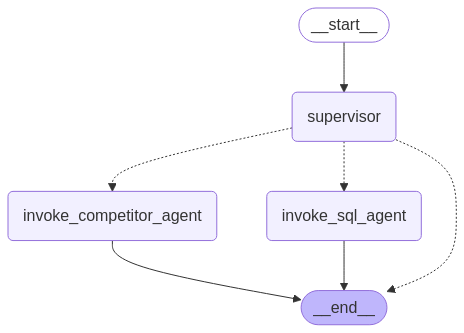

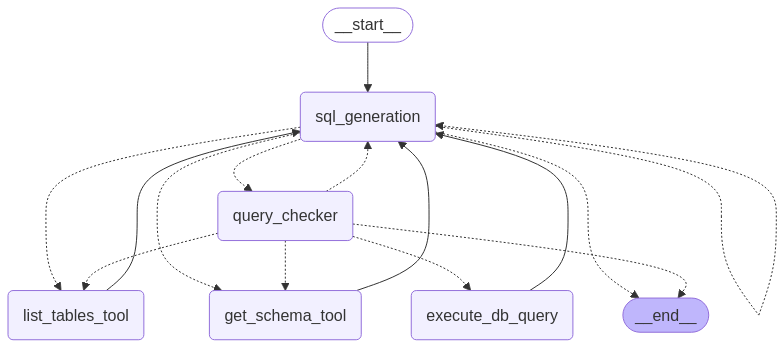

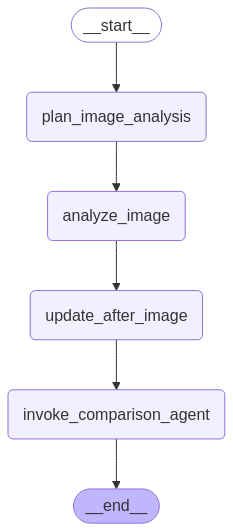

In [17]:
# Cell 8: Visualization
from IPython.display import Image, display
# If you have langgraph's drawing dependencies installed:
def display_graph(graph, name="Graph"):
    try:
        png_data = graph.get_graph().draw_mermaid_png()
        display(Image(png_data))
    except Exception as e:
        print(f"Could not draw {name}: {e}")

if app:
    display_graph(app, "Supervisor Graph")
if sql_agent_graph:
    display_graph(sql_agent_graph, "SQL Agent Sub-Graph")
if competitor_analysis_graph:
    display_graph(competitor_analysis_graph, "Competitor Analysis Sub-Graph")


## 9. Invoke Graph and Display Final Answer

We run the main application (`app`) with different requests. For an image-based competitor request, supply an existing image path (e.g. `data/competitor_menu.png`).

In [19]:
# Cell 9: Invocation Examples
if 'extract_final_response' not in globals() or not extract_final_response:
    def extract_final_response(result: dict, tool_name: str):
        messages = result.get('messages', [])
        final_answer = None
        for msg in reversed(messages):
            if isinstance(msg, AIMessage) and msg.tool_calls:
                for tc in msg.tool_calls:
                    tn = tc.get('name') if isinstance(tc, dict) else getattr(tc, 'name', None)
                    if tn == tool_name:
                        args = tc.get('args') if isinstance(tc, dict) else getattr(tc, 'args', None)
                        if args and 'answer' in args:
                            final_answer = args['answer']
                            break
            if final_answer:
                break
        if not final_answer and messages:
            final_answer = getattr(messages[-1], 'content', "No final answer.")
        return final_answer

def run_query(user_input, image_path=None):
    if not app:
        print("Supervisor app not compiled.")
        return
    print(f"\n{'-'*20} Running Query {'-'*20}")
    print(f"User Input: {user_input}")
    if image_path:
        if not os.path.exists(image_path):
            print(f"ERROR: Image file not found at '{image_path}'")
            return
        print(f"Image Path: {image_path}")
    supervisor_input = {
        "messages": [HumanMessage(content=user_input)],
        "image_path": image_path
    }
    try:
        config = RunnableConfig(recursion_limit=25)
        final_result = None
        print("--- Invoking app.stream() ---")
        for step in app.stream(supervisor_input, config=config):
            step_key = list(step.keys())[0]
            print(f"Step: {step_key}")
            final_result = step
        print("--- Stream finished ---")
        final_state_dict = final_result.get(list(final_result.keys())[0]) if final_result else {}
        final_answer = extract_final_response(final_state_dict, SubmitFinalAnswer.__name__)
        print("\nFinal Answer:\n", final_answer)
    except Exception as e:
        print(f"Error: {e}")
    print(f"{'-'*20} Finished {'-'*20}\n")

# # Example SQL
# sql_question_1 = "What drinks cost less than $2.00?"
# run_query(sql_question_1)

# sql_question_2 = "List all burgers and their prices."
# run_query(sql_question_2)

# Example Competitor
competitor_request = "Compare our menu prices for burgers to the competitor menu in the image." 
competitor_image_path = os.path.join(DATA_DIR, "competitor_menu.png")
run_query(competitor_request, image_path=competitor_image_path)



-------------------- Running Query --------------------
User Input: Compare our menu prices for burgers to the competitor menu in the image.
Image Path: ./data\competitor_menu.png
--- Invoking app.stream() ---
--- Running Node: supervisor ---
Supervisor: Has image path provided? True
Supervisor: Analyzing message: Compare our menu prices for burgers to the competitor menu in the image....
Supervisor: LLM suggested route: 'COMPETITOR_AGENT'
Supervisor: Routing to COMPETITOR_AGENT (LLM agreed and image present).
--- Routing request based on supervisor decision: COMPETITOR_AGENT ---
Routing to: invoke_competitor_agent
Step: supervisor
--- Running Node: invoke_competitor_agent ---
Invoke Competitor Agent: Calling sub-graph with image path: ./data\competitor_menu.png
Invoke Competitor Agent: Initial messages count: 1
--- Running Node: plan_image_analysis ---
plan_image_analysis: Prepared tool call for analyze_competitor_menu_image
Invoking ToolNode with tools: ['analyze_competitor_menu_ima

## 10. Conclusion

This notebook demonstrated extending a LangGraph SQL agent with a multimodal capability for competitor menu analysis. We used a supervisor pattern to route requests, allowing modular and complex agent behaviors. The competitor analysis agent leverages a multimodal LLM for image understanding, reuses existing SQL tools for internal data retrieval, and compares the results.